In [2]:
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../')
from genesis import *

import pandas_profiling as pp
import missingno as msno

In [3]:
from datetime import date
DATE_RANGE = pd.date_range(date(2000,1,3), date(2021,8,1), freq='B')

# Price Data 

In [6]:
raw_data = pd.read_csv("../../Dymon/Code Data/NUS_Data.csv", index_col=0, header=1)

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
fx = raw_data[[x for x in list(raw_data) if ("USD" in x or "+1" in x)]]
spot_ndf = fx[[x for x in fx.columns if fx.loc["field", x] == "PX_LAST"]]
spot_ndf = spot_ndf.iloc[2:,:]
spot_ndf.columns = ["EURUSD", "GBPUSD", "AUDUSD", "NZDUSD", "USDJPY", "USDCAD", "USDSEK", "USDNOK", 
                    "USDCNY", "USDCNH", "USDSGD", "USDCHF", "USDTHB", "USDIDR", "USDINR", "USDMYR",
                    "USDTWD", "USDKRW", "USDPHP"]
spot_ndf.index.name = "date"
spot_ndf.index = pd.to_datetime(spot_ndf.index)
spot_ndf = spot_ndf.astype(float)
spot_ndf = spot_ndf.loc[DATE_RANGE]
spot = spot_ndf.copy()


In [8]:
fp = raw_data[[x for x in list(raw_data) if x in ["IHN1M CMPN Curncy", "IRN1M CMPN Curncy", "MRN1M CMPN Curncy", "NTN1M CMPN Curncy", "KWN1M CMPN Curncy", "PPN1M CMPN Curncy"]]].iloc[2:]
fp.columns = ["USDIDR", "USDINR", "USDMYR", "USDTWD", "USDKRW", "USDPHP"]
fp = fp.astype(float)
fp.index = pd.to_datetime(fp.index)
fp = fp.loc[DATE_RANGE]

In [9]:
spot["USDIDR"] = spot_ndf["USDIDR"] - fp["USDIDR"]
spot["USDINR"] = spot_ndf["USDINR"] - fp["USDINR"]/100
spot["USDMYR"] = spot_ndf["USDMYR"] - fp["USDMYR"]/10000
spot["USDTWD"] = spot_ndf["USDTWD"] - fp["USDTWD"]
spot["USDKRW"] = spot_ndf["USDKRW"] - fp["USDKRW"]
spot["USDPHP"] = spot_ndf["USDPHP"] - fp["USDPHP"]

In [10]:
# spot_rtns = spot.loc["2006":].pct_change()
spot_rtns = spot.pct_change()
spot_rtns_copy = copy(spot_rtns)

spot_rtns = pd.DataFrame()
for i in list(spot_rtns_copy):
  if i[:3] != "USD":
    col = spot_rtns_copy.loc[:,i] * -1
    col.name = i[3:] + i[:3]
  else:
    col = spot_rtns_copy.loc[:,i]
    col.name = i
  spot_rtns = pd.concat([spot_rtns, col], axis = 1)
  
spot_rtns.index = pd.to_datetime(spot_rtns.index)
spot_rtns = spot_rtns
spot_rtns.drop(labels=["USDCNY"],axis=1,inplace=True)

In [13]:
px = read_prices("../../Dymon/Code Data/carry_adj_fx_returns.csv")
px.columns = [x[0] for x in px.columns]
rtns = px.pct_change()

rtns_copy = copy(rtns)

rtns = pd.DataFrame()
for i in list(rtns_copy):
  if i[:3] != "USD":
    col = rtns_copy.loc[:,i] * -1
    col.name = i[3:] + i[:3]
  else:
    col = rtns_copy.loc[:,i]
    col.name = i
  rtns = pd.concat([rtns, col], axis = 1)
  
  
# rtns = px.pct_change()
rtns.index = pd.to_datetime(rtns.index)
rtns = rtns
rtns.drop(labels=["USDCNY"],axis=1,inplace=True)

In [14]:
# rtns = rtns[["USDAUD", "USDCAD", "USDEUR", "USDGBP", "USDJPY", "USDNZD", "USDSEK", "USDNOK", "USDCHF"]]
rtns = rtns[[x for x in list(rtns) if x not in ["USDAUD", "USDCAD", "USDEUR", "USDGBP", "USDJPY", "USDNZD", "USDSEK", "USDNOK", "USDCHF"]]]

In [15]:
spot_rtns = spot_rtns[list(rtns)].loc[:"2016"]
carry_rtns = (rtns - spot_rtns).loc[:"2016"]


In [16]:
spot_copy = copy(spot)

spot = pd.DataFrame()
for i in list(spot_copy):
  if i[:3] != "USD":
    col = spot_copy.loc[:,i] * -1
    col.name = i[3:] + i[:3]
  else:
    col = spot_copy.loc[:,i]
    col.name = i
  spot = pd.concat([spot, col], axis = 1)
  
spot.index = pd.to_datetime(spot.index)
spot.drop(labels=["USDCNY"],axis=1,inplace=True)
spot = spot[list(rtns)].loc[:"2016"]

# Settings

In [17]:
s = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Other Data

# Signal 

<AxesSubplot:>

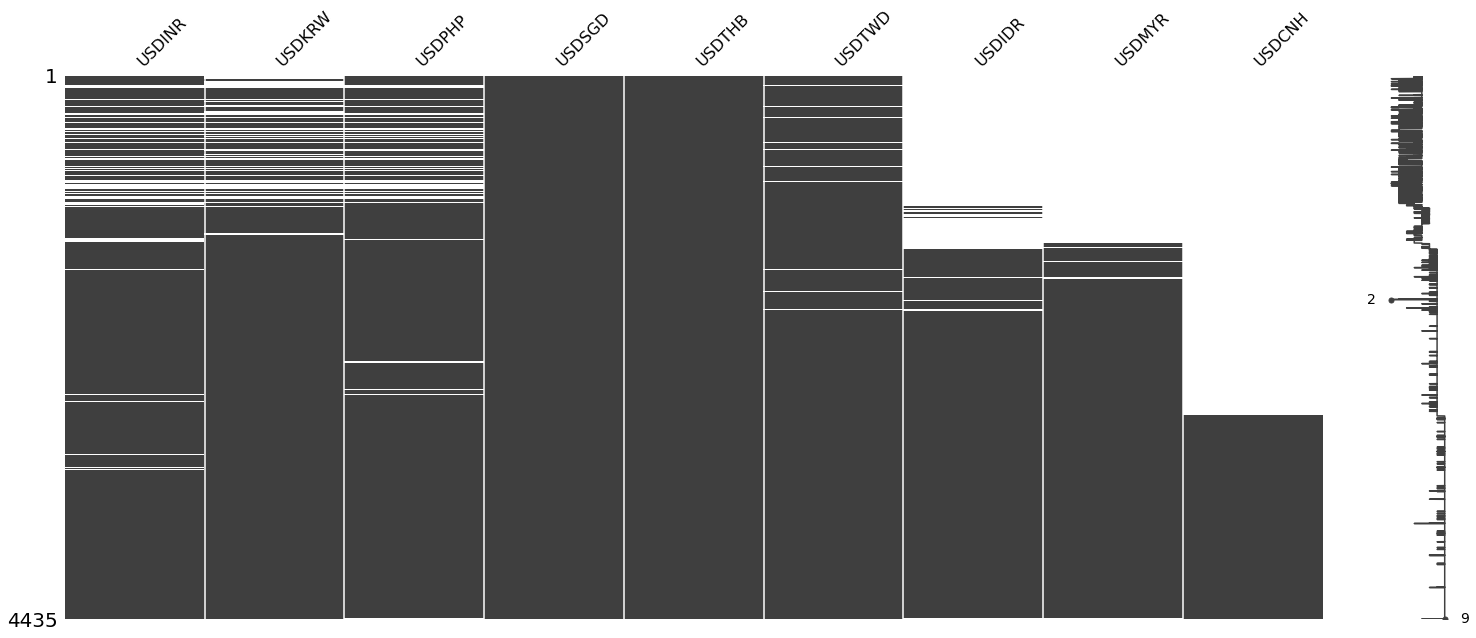

In [54]:
msmx(spot)

In [45]:
a = spot.ffill()#fillna(0).pipe(omit_leading_zeros)
b = a.rolling(252).min()
c = a.rolling(252).max()
sig = ((a-b)/(b-c)).pipe(zscore, 252) * -1
sig = sig.sub(sig.mean(axis=1), axis=0)
sig = CAP(sig, 2.5).pipe(rolling_mean, 5)

In [42]:
sig = spot_rtns.ffill().pct_change(252*6)

In [43]:
sig = sig.sub(sig.mean(axis=1), axis=0)

In [44]:
sig = CAP(sig, 2.5)

In [46]:
b = Backtest(signal = sig, asset_returns = rtns, tcost = abs(rtns*0), settings = s)
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [47]:
bt_obj = b

In [48]:
get_summary(bt_obj)

Returns   : 0.09380193813780537
Vol       : 0.11036343828837646
SR        : 0.8499367144824143
Max DD    : -26.91
Hit rate  : 0.532
W | N | L : 0.53 | 0.0 | 0.47
W/L Ratio : 1.14


In [49]:
get_returns_stats(bt_obj.asset_rtn.loc["2003":], b.wts.loc["2003":])

,USDINR,USDKRW,USDPHP,USDSGD,USDTHB,USDTWD,USDIDR,USDMYR,USDCNH
annualized_return,2.650089,0.377636,1.283468,0.992873,1.493812,0.303763,-0.422039,-0.044828,0.63798
sharpe,0.53865,0.083278,0.280562,0.288991,0.338726,0.07171,-0.09214,-0.014972,0.182914
dollar_sharpe,0.45653,0.064093,0.247275,0.284706,0.292828,0.048743,-0.119089,-0.029112,0.157932
trade_sharpe,0.53865,0.083278,0.280562,0.288991,0.338726,0.07171,-0.09214,-0.014972,0.182914
long_sharpe,0.175086,-0.230833,-0.218212,-0.107414,-0.70131,0.022408,-0.415134,-0.188257,0.661888
short_sharpe,0.93872,0.588753,0.629972,0.711537,1.226883,0.116173,0.304742,0.124171,-0.018271
sortino,0.348085,0.048102,0.166486,0.168344,0.216639,0.04179,-0.045229,-0.007261,0.045431
max_drawdown,-12.405992,-17.059389,-12.301605,-8.799449,-18.699782,-11.668991,-14.539913,-17.14864,-18.948974
max_drawdown_start,2012-06-22,2004-12-06,2007-08-16,2003-01-24,2011-01-28,2004-04-13,2008-08-05,2011-05-23,2014-04-29
max_drawdown_end,2016-12-28,2010-11-23,2013-05-08,2004-09-28,2012-09-26,2007-12-17,2015-01-30,2016-01-08,2015-09-01


In [50]:
def plot_bt(bt_obj):
  gs = GridSpec(nrows = 4, ncols = 3)
  fig = plt.figure(figsize=(30, 30))
  fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

  fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
  fig.add_subplot(gs[1]).set_label(gen_plot_rtn(bt_obj.model_rtn["2012":], main = "Returns (2012/)"))
  fig.add_subplot(gs[2]).set_label(gen_rtn_asset(bt_obj))

  fig.add_subplot(gs[3]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
  fig.add_subplot(gs[4]).set_label(gen_rtn_component(bt_obj, spot_rtns, carry_rtns))
  fig.add_subplot(gs[5]).set_label(gen_rtn_longshort(bt_obj))

  fig.add_subplot(gs[6]).set_label(gen_leadlag(bt_obj, nlag=10))
  fig.add_subplot(gs[7]).set_label(gen_rolling_winloss(bt_obj.model_rtn))
  fig.add_subplot(gs[8]).set_label(gen_rolling_hitrate(bt_obj.model_rtn))

  fig.add_subplot(gs[9]).set_label(pf.plot_annual_returns(bt_obj.model_rtn))
  fig.add_subplot(gs[10:]).set_label(gen_signal(bt_obj))

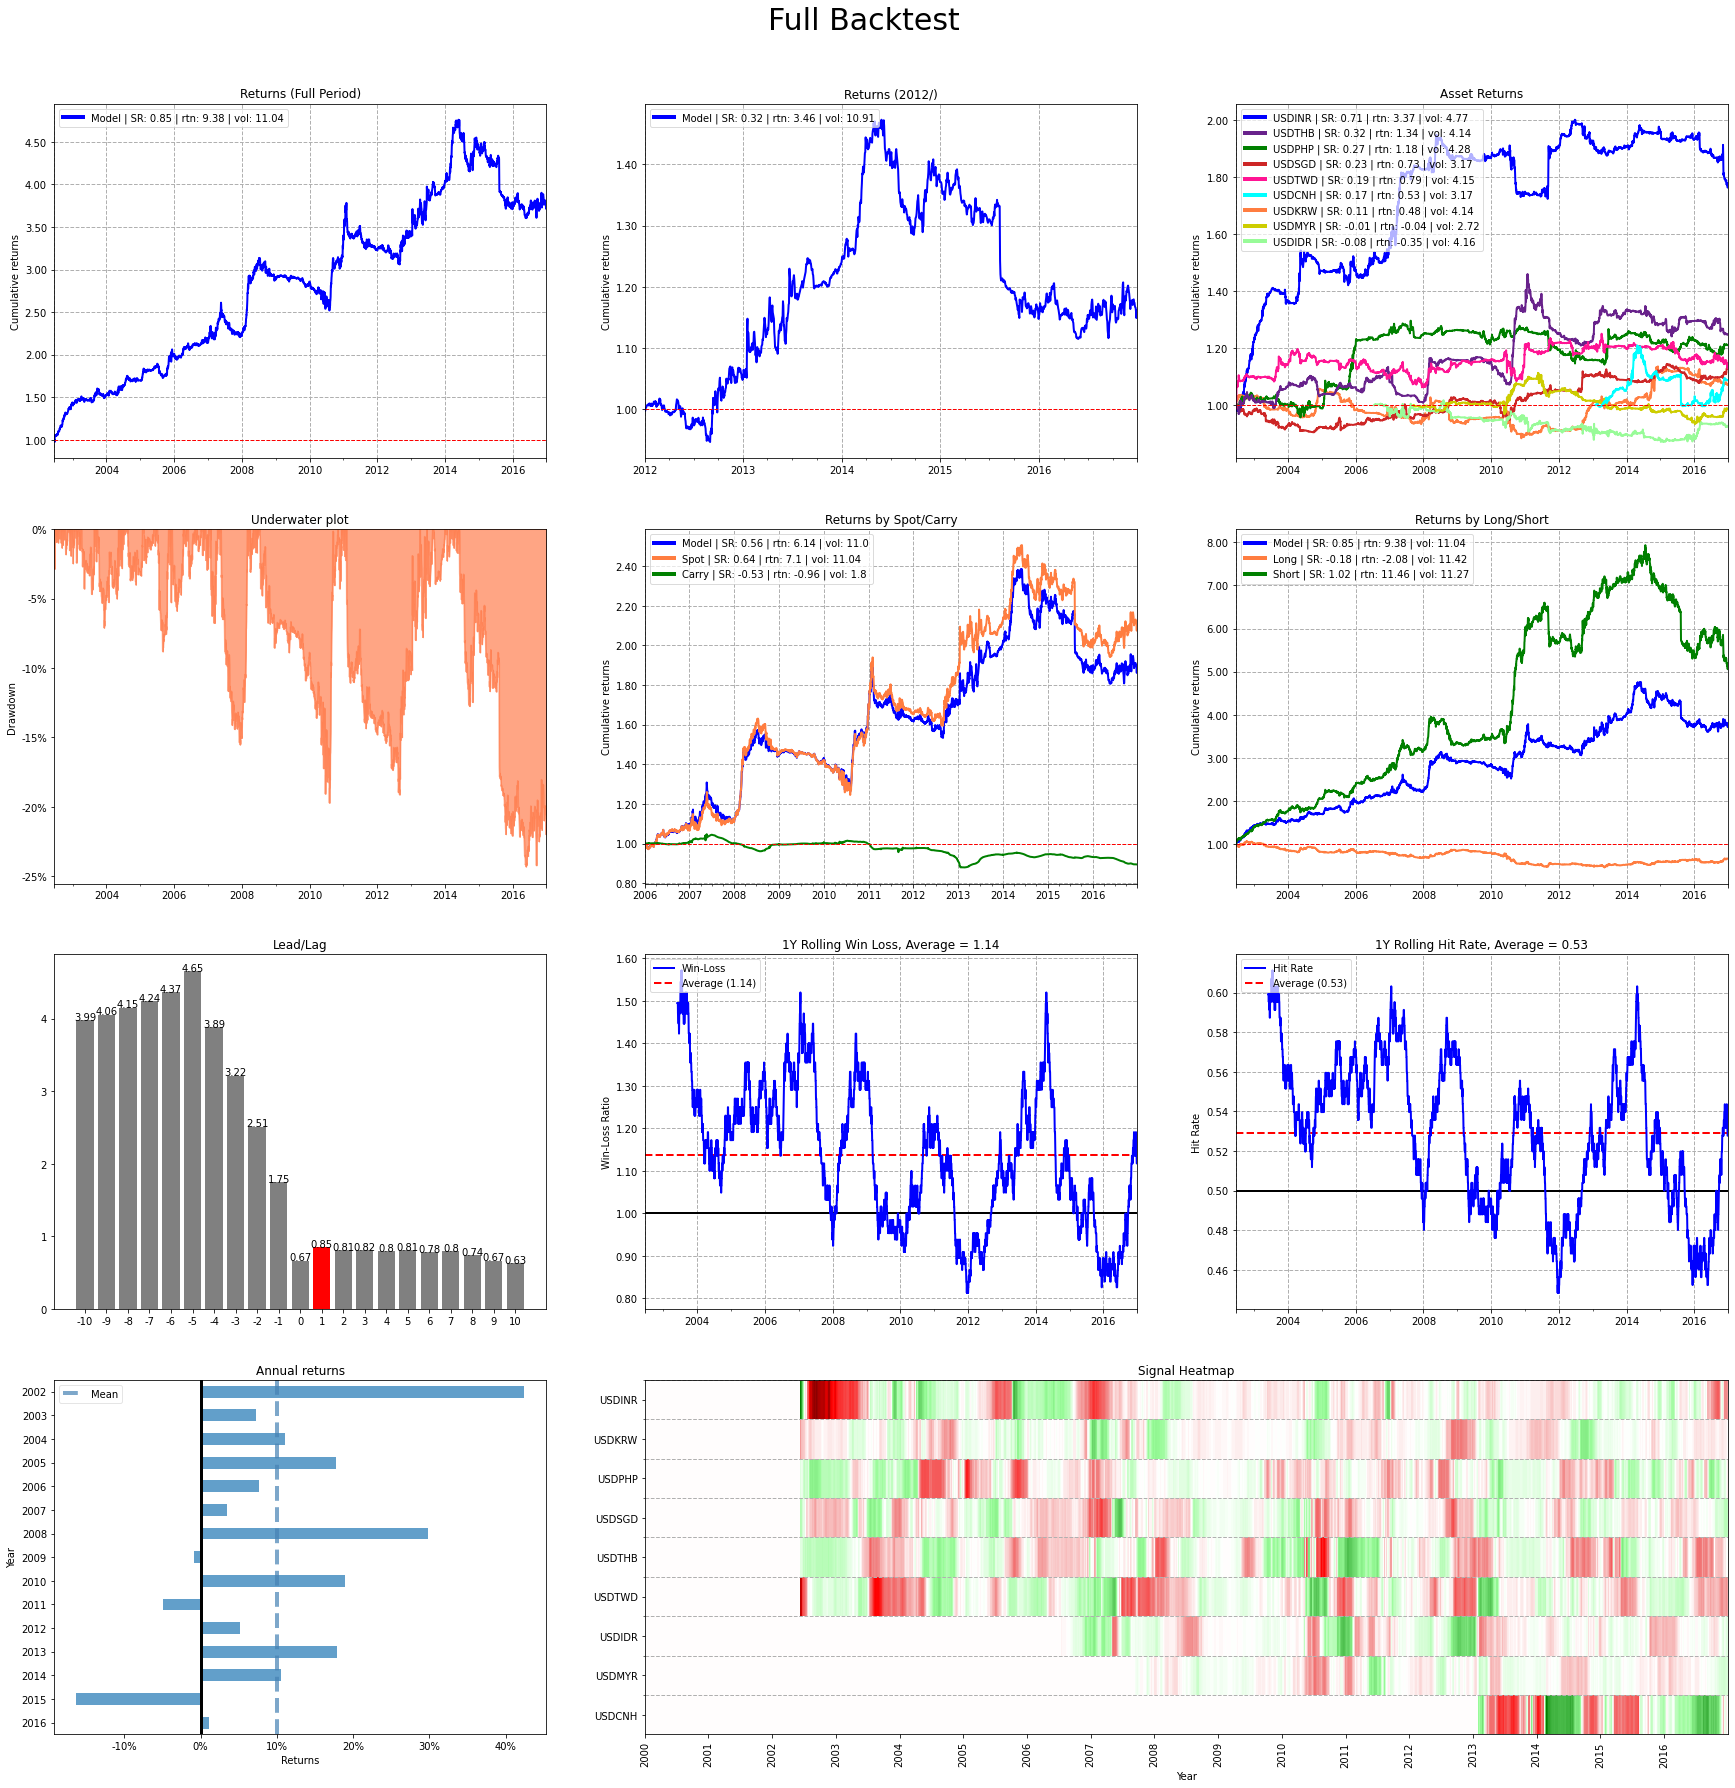

In [51]:
plot_bt(bt_obj)

In [ ]:
pf.plot_monthly_returns_heatmap(bt_obj.model_rtn)

In [ ]:
pf.plot_monthly_returns_dist(bt_obj.model_rtn)

In [ ]:
gs = GridSpec(nrows = 2, ncols = 2)
fig = plt.figure(figsize=(20, 15))
fig.suptitle(t="Full Backtest", fontsize=30, y=.925)

fig.add_subplot(gs[0]).set_label(gen_plot_rtn(bt_obj.model_rtn, main = "Returns (Full Period)"))
fig.add_subplot(gs[1]).set_label(gen_rtn_asset(bt_obj))
fig.add_subplot(gs[2]).set_label(pf.plot_drawdown_underwater(bt_obj.model_rtn))
fig.add_subplot(gs[3]).set_label(gen_rtn_longshort(bt_obj))

In [ ]:
# gen_rtn_longshort(bt_obj)
# gen_rtn_component(bt_obj, spot_rtns, carry_rtns)
# gen_leadlag(b, nlag=20)
# gen_rolling_hitrate(bt_obj.model_rtn)
# gen_rolling_winloss(bt_obj.model_rtn)
# pf.plot_monthly_returns_dist(bt_obj.model_rtn)
# pf.plot_annual_returns(bt_obj.model_rtn)
# gen_signal(bt_obj)
# gen_rtn_asset(bt_obj)
# gen_plot_rtn(bt_obj.model_rtn["2012":])
# gen_rolling_sharpe(bt_obj.model_rtn)
# gen_rtn_col_component(bt_obj, spot_rtns, carry_rtns)
# gen_rtn_col_longshort(bt_obj)